# Planar Homography

## Imports

In [496]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Auxiliar functions

In [497]:
def get_intersection(line1, line2):
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([[np.cos(theta1), np.sin(theta1)],
                 [np.cos(theta2), np.sin(theta2)]])
    b = np.array([[rho1], [rho2]])
    x, y = np.linalg.solve(A, b)
    x, y = int(x), int(y)
    return (x, y)


In [498]:
def order_points(pts):
    '''Rearrange coordinates to order:
       top-left, top-right, bottom-right, bottom-left'''
    rect = np.zeros((4, 2), dtype='float32')
    pts = np.array(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left point will have the largest difference.
    rect[3] = pts[np.argmax(diff)]
    # Return the ordered coordinates.
    return rect.astype('int').tolist()


### Read and display original image

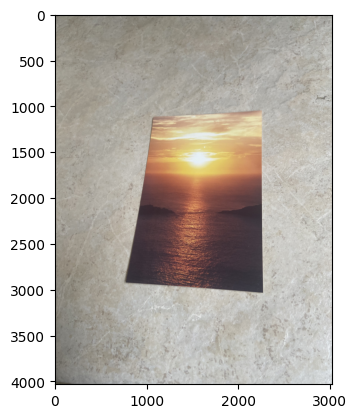

In [499]:
original = cv2.imread('../img/foto2_cap1.jpg')
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
gt = cv2.imread('../img/foto2_gt.jpg')
gt = cv2.cvtColor(gt, )
plt.imshow(original)
plt.show()

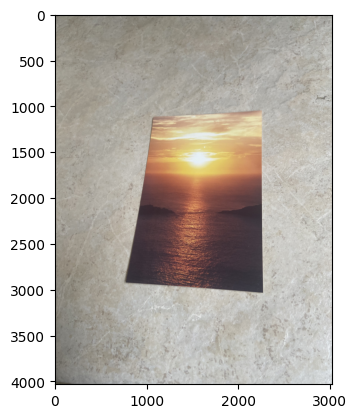

In [542]:
original = cv2.imread('../img/foto2_cap1.jpg')
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
gt = cv2.imread('../img/foto2_gt.jpg')
gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)
plt.imshow(original)
plt.show()

In [500]:
h, w, c = original.shape
print('original dimensions')
print(f'image height: {h}, image width: {w}, color channels: {c}')

original dimensions
image height: 4032, image width: 3024, color channels: 3


### Resize to workable dims

In [501]:
dim_limit = 1080
max_dim = max(original.shape[:2])
if max_dim > dim_limit:
    resize_scale = dim_limit / max_dim
    original = cv2.resize(original, None, fx=resize_scale, fy=resize_scale)

In [502]:
h, w, c = original.shape
print('resized dimensions')
print(f'image height: {h}, image width: {w}, color channels: {c}')

resized dimensions
image height: 1080, image width: 810, color channels: 3


### Image transforms and morph ops

In [503]:
# convert image to grayscale/blurred versions
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image to create a binary image
ret, thresh = cv2.threshold(
    blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# perform morphological transformations to remove noise
kernel = np.ones((24, 24), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=3)

### Background and foreground analysis

In [504]:
# sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=35)

# find sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

# find unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# add one to all labels so that sure background is not 0, but 1
markers = markers+1

# mark the region of unknown with zero
markers[unknown == 255] = 0

### Watershed

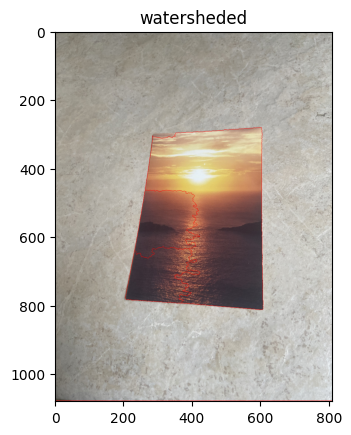

In [505]:
watersheded = original.copy()
markers = cv2.watershed(watersheded, markers)
watersheded[markers == -1] = [255, 0, 0]
plt.imshow(watersheded)
plt.title('watersheded')
plt.show()

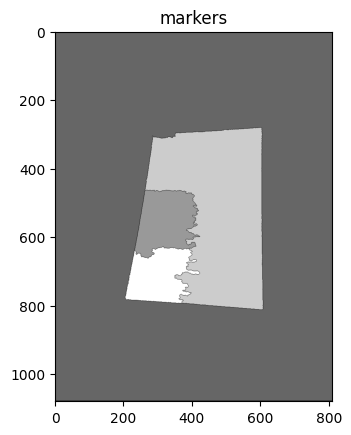

In [506]:
plt.imshow(markers, cmap='gray')
plt.title('markers')
plt.show()

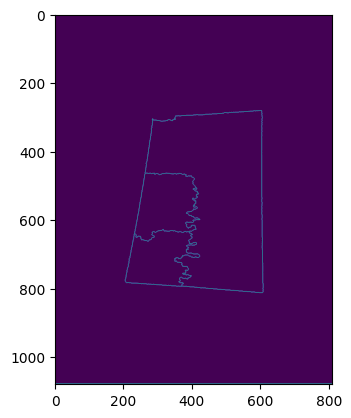

In [507]:
# generate mask image
mask = np.zeros(original.shape[:2], np.uint8)
mask[markers == -1] = 255
plt.imshow(mask)
plt.show()

### Hough lines

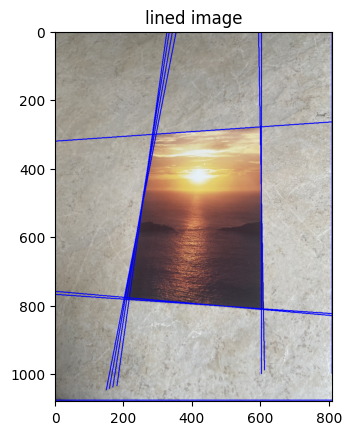

In [508]:
#  perform hough line transform over the mask
lines = cv2.HoughLines(mask, 2, np.pi/180, 150)

# draw lines on the image
lined_img = original.copy()
for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(lined_img, (x1, y1), (x2, y2), (0, 0, 255), 2)

# show the image with the lines drawn on it
plt.imshow(lined_img)
plt.title('lined image')
plt.show()


[GRAB INTERSECTIONS](https://stackoverflow.com/a/46572063)

In [509]:
from collections import defaultdict


def segment_by_angle_kmeans(lines, k=2, **kwargs):
    """Groups lines based on angle with k-means.

    Uses k-means on the coordinates of the angle on the unit circle
    to segment `k` angles inside `lines`.
    """

    # Define criteria = (type, max_iter, epsilon)
    default_criteria_type = cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER
    criteria = kwargs.get('criteria', (default_criteria_type, 10, 1.0))
    flags = kwargs.get('flags', cv2.KMEANS_RANDOM_CENTERS)
    attempts = kwargs.get('attempts', 10)

    # returns angles in [0, pi] in radians
    angles = np.array([line[0][1] for line in lines])
    # multiply the angles by two and find coordinates of that angle
    pts = np.array([[np.cos(2*angle), np.sin(2*angle)]
                   for angle in angles], dtype=np.float32)

    # run kmeans on the coords
    labels, centers = cv2.kmeans(pts, k, None, criteria, attempts, flags)[1:]
    labels = labels.reshape(-1)  # transpose to row vec

    # segment lines based on their kmeans label
    segmented = defaultdict(list)
    for i, line in enumerate(lines):
        segmented[labels[i]].append(line)
    segmented = list(segmented.values())
    return segmented

In [510]:
segmented = segment_by_angle_kmeans(lines)

In [511]:
def intersection(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.

    Return closest integer pixel locations.
    See https://stackoverflow.com/a/383527/5087436
    """
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [[x0, y0]]

def segmented_intersections(lines):
    """Finds the intersections between groups of lines"""

    intersections = []
    for i, group in enumerate(lines[:-1]):
        for next_group in lines[i+1:]:
            for line1 in group:
                for line2 in next_group:
                    intersections.append(intersection(line1, line2))
    
    return intersections

In [512]:
intersections = segmented_intersections(segmented)

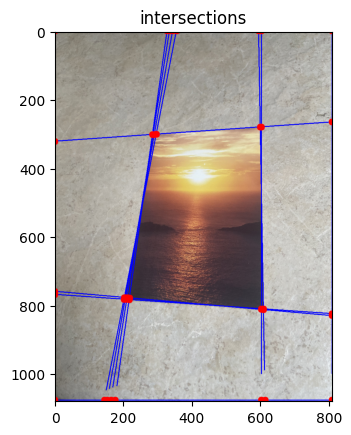

In [513]:
corners = lined_img.copy()
for point in intersections:
    corners = cv2.circle(corners, point[0], radius=10, color=(255,0,0), thickness=-1)

plt.imshow(corners)
plt.title('intersections')
plt.show()

In [514]:
new_points = []
for point in intersections:
    if point[0].count(-1):
        pass
    else:
        new_points.append(point[0])

In [515]:
final_points = []

# removing outliers closest to image borders
for point in new_points:
    point_w = point[0]
    point_h = point[1]
    if point_w > ((w * 94) / 100) or point_h > ((h * 94) / 100):
        pass
    else:
        final_points.append(point)

In [516]:
print(new_points)
print(final_points)

[[807, 1077], [807, 830], [807, 265], [807, 825], [612, 1077], [607, 813], [598, 280], [607, 811], [601, 1077], [601, 812], [601, 280], [601, 811], [152, 1077], [205, 778], [289, 302], [204, 783], [163, 1077], [210, 778], [285, 302], [209, 783], [144, 1077], [202, 778], [295, 301], [201, 783], [175, 1077], [217, 779], [284, 302], [216, 784]]
[[607, 813], [598, 280], [607, 811], [601, 812], [601, 280], [601, 811], [205, 778], [289, 302], [204, 783], [210, 778], [285, 302], [209, 783], [202, 778], [295, 301], [201, 783], [217, 779], [284, 302], [216, 784]]


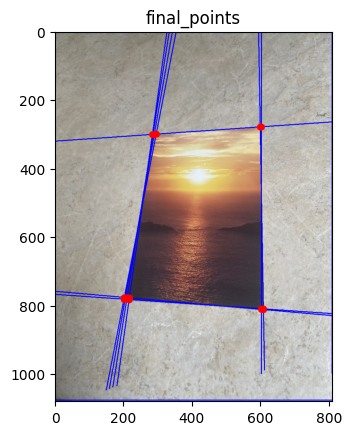

In [517]:
corners = lined_img.copy()
for point in final_points:
    corners = cv2.circle(
        corners, point, radius=10, color=(255, 0, 0), thickness=-1)

plt.imshow(corners)
plt.title('final_points')
plt.show()

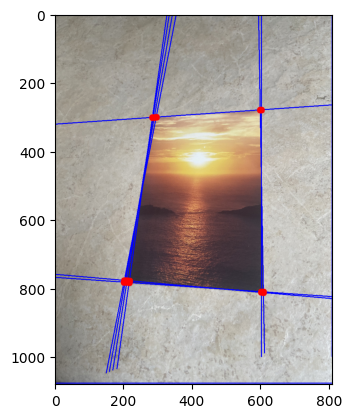

In [518]:
corners = lined_img.copy()
for point in final_points:
    corners = cv2.circle(corners, point, radius=10, color=(255,0,0), thickness=-1)

plt.imshow(corners)
plt.show()


#### K-means

In [519]:
points = []
for point in final_points:
    points.append(point)

In [520]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto").fit(points)

In [521]:
cornered_img = original.copy()
centers = list(kmeans.cluster_centers_.astype(int))
centers = [list(point) for point in centers]

In [528]:
# rearranging corners order
corners = order_points(centers)

In [529]:
for point in centers:
    cornered_img = cv2.circle(
        cornered_img, point, radius=10, color=(255, 0, 0), thickness=-1)

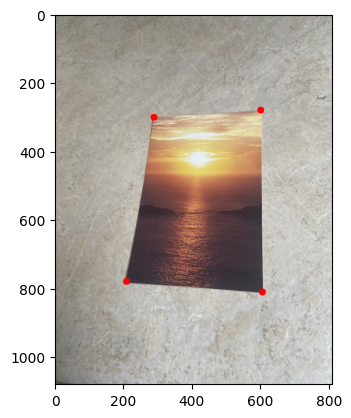

In [530]:
plt.imshow(cornered_img)
plt.show()

## Finding destination co-ordinates

In [532]:
(tl, tr, br, bl) = corners

# finding max width
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
maxWidth = max(int(widthA), int(widthB))

# finding max height
heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
maxHeight = max(int(heightA), int(heightB))

# final destination coords
destination_corners = [
    [0, 0],
    [maxWidth, 0],
    [maxWidth, maxHeight],
    [0, maxHeight]]

print(destination_corners)

[[0, 0], [397, 0], [397, 531], [0, 531]]


## Homography

In [535]:
# getting homog
homography = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))
# warping
final = cv2.warpPerspective(original, np.float32(homography), (maxWidth, maxHeight), flags=cv2.INTER_LINEAR)

## Results

### Original vs Processed

Text(0.5, 1.0, 'Scanned Form')

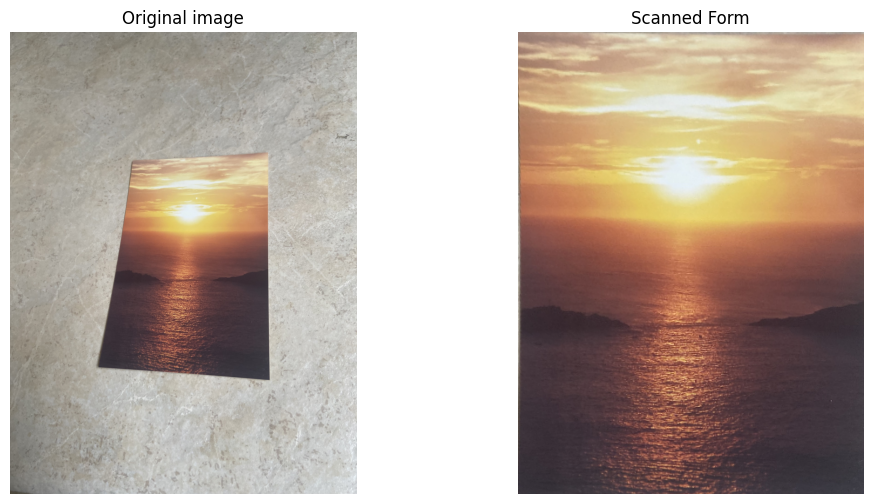

In [544]:
# Display results
plt.figure(figsize=[12, 6])
plt.subplot(121)
plt.imshow(original)
plt.axis('off')
plt.title("Original image")
plt.subplot(122)
plt.imshow(final)
plt.axis('off')
plt.title("Scanned Form")


### Ground Truth vs Processed

Text(0.5, 1.0, 'Scanned Form')

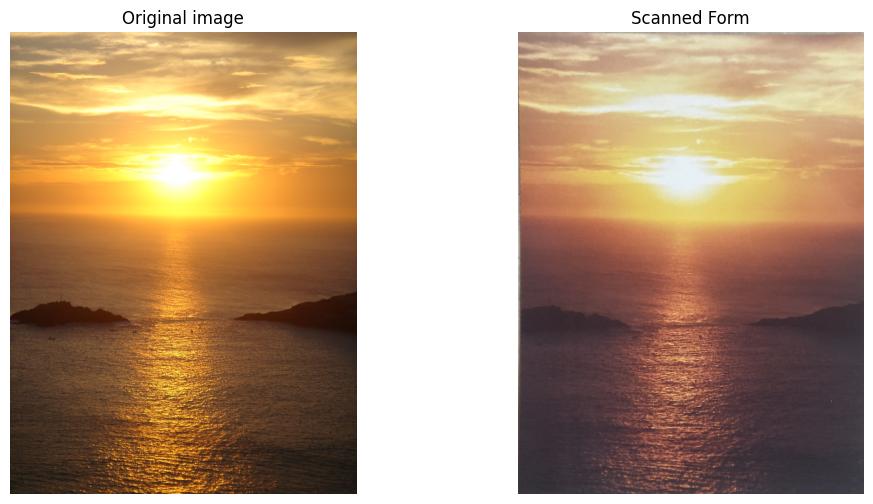

In [545]:
# Display results
plt.figure(figsize=[12, 6])
plt.subplot(121)
plt.imshow(gt)
plt.axis('off')
plt.title("Original image")
plt.subplot(122)
plt.imshow(final)
plt.axis('off')
plt.title("Scanned Form")


## Evaluations

### PSNR